In [1]:
company_output = 'PETR4.SA'
end_date = '2024-11-15' 
start_date = '2024-06-01'
stock_var = 'Adj Close'
company_inputs = 'PETR4.SA'

seq_length = 30
batch_size = 30
h = 1

In [2]:
import mlflow
import mlflow.sklearn

scalerX_path = 'artifacts/transformers/scalerX'
scalery_path = 'artifacts/transformers/scalery'
model_path = 'artifacts/models_tf/best_models'

scalerX = mlflow.sklearn.load_model(scalerX_path)
scalery = mlflow.sklearn.load_model(scalery_path)
model = mlflow.sklearn.load_model(model_path)

In [3]:
from feature_engineering import get_finance_df, shift_drop_na_in_xy

df = get_finance_df(company_inputs, start_date, end_date, stock_var)

if (len(df) <= seq_length+h+1):
    raise Exception("Your dataset 'df' has less samples than the defined window size for data transformation, given by 'seq_length'")

X, y = shift_drop_na_in_xy(df, company_inputs, company_output, horizon_pred=h)

[*********************100%***********************]  1 of 1 completed


In [4]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

def make_predictions(X, y, seq_length, batch_size, scaler):

    generator = TimeseriesGenerator(X, y, length=seq_length, batch_size=batch_size)

    scaled_X = []
    y_pred = []
    for k in range(len(generator)):
        X_temp, _ = generator[k]
        scaled_X = scaler.transform(X_temp.reshape(-1,1)).reshape(len(X_temp),seq_length)

        y_pred_scaled = model.predict(scaled_X)
        y_pred.append(scaler.inverse_transform(y_pred_scaled.reshape(-1,1)))
        
    y_pred = np.concatenate(y_pred, axis=0 )
    return y_pred

In [5]:
y_pred = make_predictions(X, X, seq_length, batch_size, scalerX)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


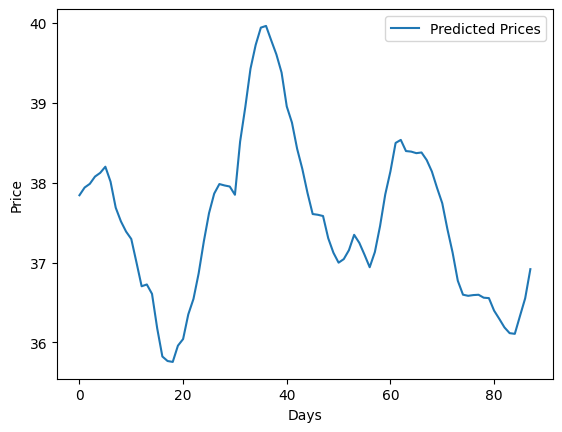

In [6]:
import matplotlib.pyplot as plt

# Plot the predicted prices\n"
plt.plot(y_pred, label="Predicted Prices")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()